In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
grid_size = 10  # Fluid grid resolution
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.01
threshold = 0.4  # For block placement

# MNIST dataset
transform = transforms.Compose([
    transforms.Resize((grid_size, grid_size)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transform,
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

class PotentialFlowSolver(nn.Module):
    def __init__(self, iterations=50):
        super().__init__()
        self.iterations = iterations
        
    def forward(self, obstacles):
        batch_size = obstacles.shape[0]
        phi = torch.zeros_like(obstacles).to(obstacles.device)
        
        # Solve Laplace equation ∇²φ = 0 with Neumann BCs
        for _ in range(self.iterations):
            phi_new = phi.clone()
            
            # Central difference scheme
            phi_new[:, 1:-1, 1:-1] = 0.25 * (
                phi[:, :-2, 1:-1] + phi[:, 2:, 1:-1] +
                phi[:, 1:-1, :-2] + phi[:, 1:-1, 2:]
            )
            
            # Apply boundary conditions (zero gradient at obstacles)
            phi = torch.where(obstacles > 0.5, phi, phi_new)
            
        # Calculate velocity components (central differences)
        u = (phi[:, 2:, 1:-1] - phi[:, :-2, 1:-1]) / 2  # ∂φ/∂x
        v = (phi[:, 1:-1, 2:] - phi[:, 1:-1, :-2]) / 2  # ∂φ/∂y
        
        # Pad edges to maintain original size
        u = torch.nn.functional.pad(u, (0, 0, 1, 1))
        v = torch.nn.functional.pad(v, (1, 1, 0, 0))
        
        return torch.stack((u, v), dim=1)  # Shape: [batch, 2, grid, grid]

class FluidDigitClassifier(nn.Module):
    def __init__(self, grid_size):
        super().__init__()
        self.flow_solver = PotentialFlowSolver()
        self.classifier = nn.Linear(2 * grid_size * grid_size, num_classes)
        
    def forward(self, x):
        # 1. Direct block placement from input
        obstacles = (x.squeeze(1) > threshold).float()  # Binary blocks
        
        # 2. Simulate fluid flow
        velocity_field = self.flow_solver(obstacles)
        
        # 3. Flatten velocity magnitudes for classification
        features = velocity_field.view(velocity_field.size(0), -1)
        return self.classifier(features)

# Initialize model
model = FluidDigitClassifier(grid_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Visualization
def visualize_sample(image, obstacle_map, velocity_field):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Original Digit')
    
    plt.subplot(1, 3, 2)
    plt.imshow(obstacle_map, cmap='binary')
    plt.title('Block Placement')
    
    plt.subplot(1, 3, 3)
    plt.quiver(velocity_field[0, :, :], velocity_field[1, :, :])
    plt.title('Velocity Field')
    
    plt.tight_layout()
    plt.show()

# Visualize first test sample
test_sample, test_label = next(iter(test_loader))
with torch.no_grad():
    obstacles = (test_sample[0].squeeze() > threshold).float()
    velocity = model.flow_solver(obstacles.unsqueeze(0).to(device))[0].cpu()
    
visualize_sample(test_sample[0], obstacles, velocity.numpy())

RuntimeError: stack expects each tensor to be equal size, but got [100, 10, 8] at entry 0 and [100, 8, 10] at entry 1

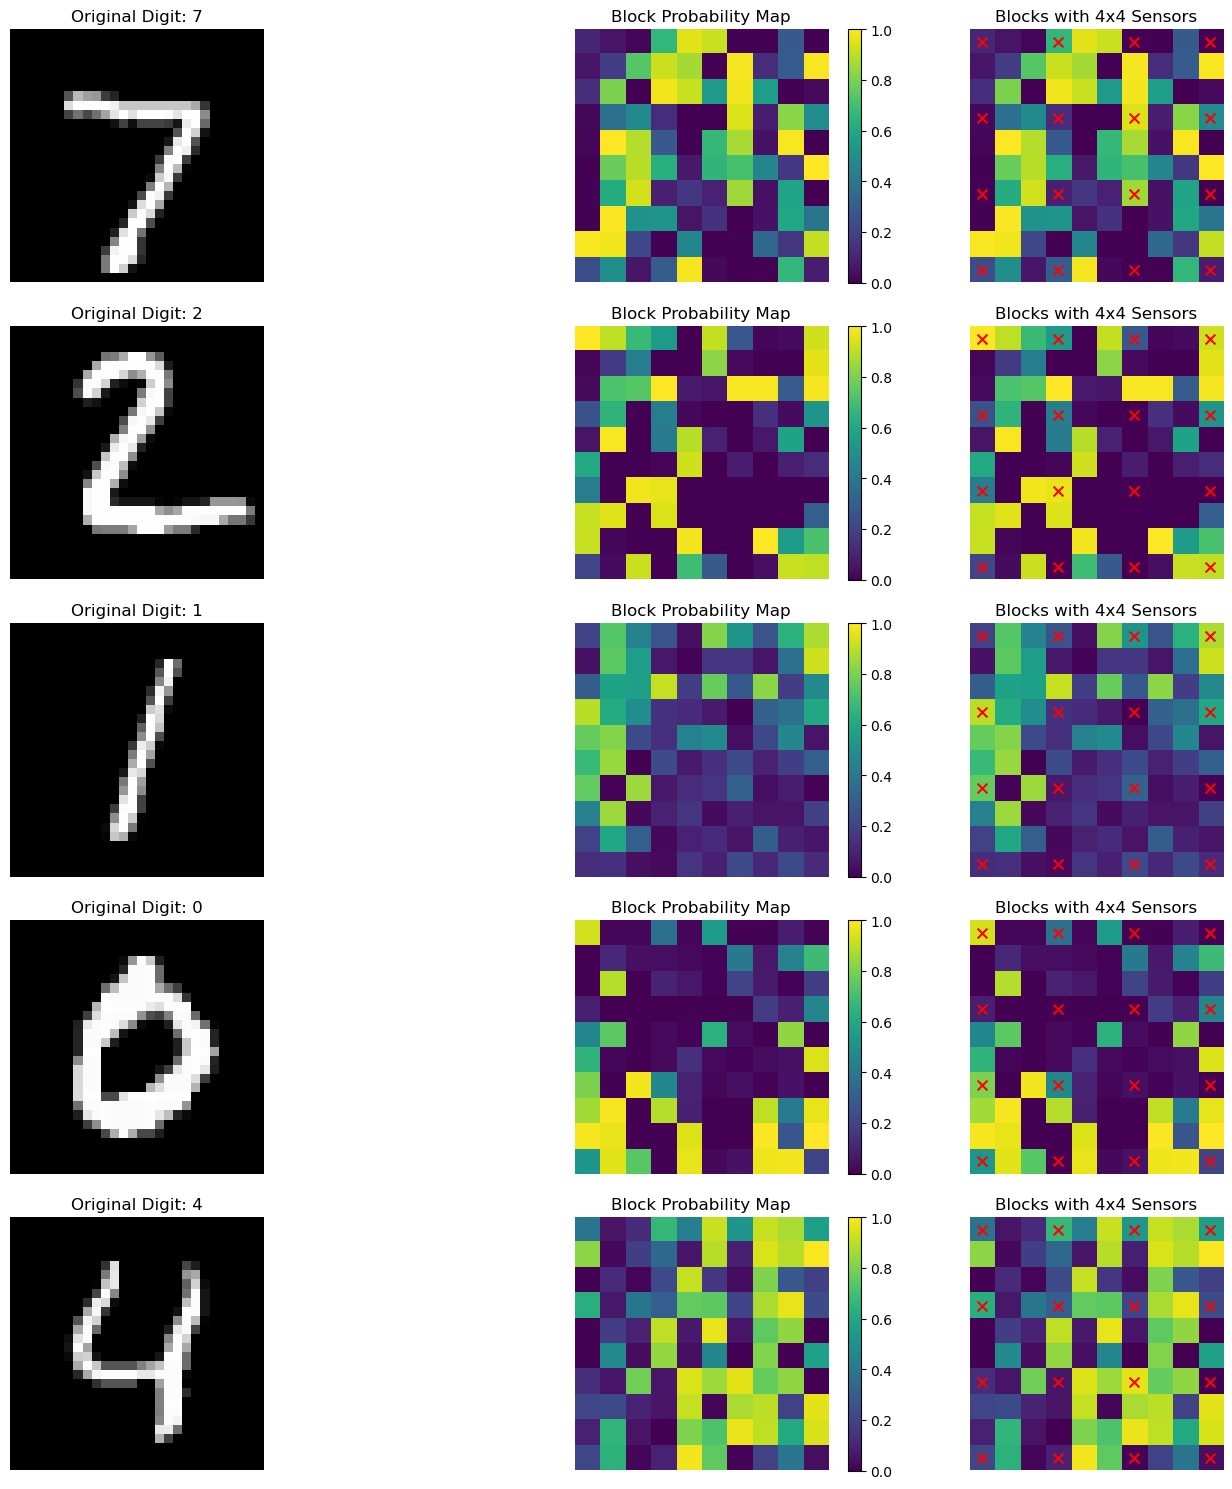

In [4]:
def visualize_blocks_and_sensors(model, test_loader, num_samples=5, sensor_grid_size=4):
    # Get a full batch and select subset
    samples, labels = next(iter(test_loader))
    samples = samples[:num_samples]  # Correct subset selection
    samples = samples.to(device)
    
    # Generate block positions with proper flattening
    model.eval()
    with torch.no_grad():
        # Flatten only the selected samples
        inputs = samples.view(num_samples, -1)  # Shape [5, 784]
        block_maps = model.block_generator(inputs).cpu().numpy()
    
    # Create sensor grid positions
    sensor_x = np.linspace(0, 9, sensor_grid_size, dtype=int)
    sensor_y = np.linspace(0, 9, sensor_grid_size, dtype=int)
    sensor_positions = np.array(np.meshgrid(sensor_x, sensor_y)).T.reshape(-1, 2)
    
    # Visualization code remains the same
    plt.figure(figsize=(15, 3*num_samples))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(samples[i].cpu().squeeze(), cmap='gray')
        plt.title(f'Original Digit: {labels[i].item()}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 2)
        block_map = block_maps[i].reshape(10, 10)
        plt.imshow(block_map, cmap='viridis', vmin=0, vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title('Block Probability Map')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(block_map, cmap='viridis', vmin=0, vmax=1)
        for x, y in sensor_positions:
            plt.scatter(x, y, s=50, c='red', marker='x', linewidths=1.5)
        plt.title(f'Blocks with {sensor_grid_size}x{sensor_grid_size} Sensors')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_blocks_and_sensors(model, test_loader)